In [91]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from patsy import dmatrices

#### Imports burglary report csv from question_1

In [92]:
burglary_reports = pd.read_csv("../geospatial_api-silver-sharks/data/burglary_reports.csv", engine='python')

### Downloaded census tract data and uploaded code

In [93]:
#uploads census tract geodata file downloaded from data folder
census_tract = gpd.read_file('data/tl_2019-47_tract/tl_2019_47_tract.shp')
type(census_tract)

geopandas.geodataframe.GeoDataFrame

In [94]:
print(census_tract.crs)


epsg:4269


### Added geometry column

In [100]:
#lambda function converting lat & long to Point(long, lat) format for GeoDataFrame 
burglary_reports['geometry'] = (burglary_reports
                                .apply(lambda x: 
                                       Point((x.longitude,
                                              x.latitude)),
                                       axis=1))

print(burglary_reports.shape)
display(burglary_reports.head())

(775, 7)


,Unnamed: 0,incident_reported,incident_number,offense_description,latitude,longitude,geometry
0,199,2021-01-13,20210024216,BURGLARY- AGGRAVATED,36.06,-86.95,POINT (-86.95 36.06)
1,310,2021-01-14,20210024929,BURGLARY- AGGRAVATED,36.19,-86.75,POINT (-86.75 36.19)
2,434,2021-01-14,20210026105,BURGLARY- AGGRAVATED,36.18,-86.75,POINT (-86.75 36.18)
3,450,2021-01-14,20210026189,BURGLARY- AGGRAVATED,36.04,-86.73,POINT (-86.73 36.04)
4,495,2021-01-14,20210026468,BURGLARY- AGGRAVATED,36.16,-86.85,POINT (-86.84999999999999 36.16)


In [109]:
burglary_geo = gpd.GeoDataFrame(burglary_reports,
                               crs=census_tract.crs,
                               geometry = burglary_reports['geometry'])

### Cleaning up and joining burglary and tract data

In [118]:
#shrinks census tract dataframe to only relative columns
census_tract = census_tract[['COUNTYFP', 'TRACTCE', 'NAME', 'geometry']]

#converts county code to number 
census_tract['COUNTYFP'] = census_tract['COUNTYFP'].apply(pd.to_numeric)

#filters out all counties but Davidson county 
census_tract = census_tract[census_tract['COUNTYFP'] == 37]
census_tract.head()

,COUNTYFP,TRACTCE,NAME,geometry
27,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
36,37,010103,101.03,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."
37,37,010202,102.02,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
38,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
63,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."


In [119]:
#joins burglary data with census tract data
burglary_by_tract = gpd.sjoin(burglary_geo, census_tract, op = 'within')

### Gets rid of duplicates in data and adjusts columns

In [120]:
#drops redundant index
burglary_by_tract = burglary_by_tract.drop(columns='index_right')

#renames tract column
burglary_by_tract = burglary_by_tract.rename(columns={'TRACTCE':'tract'})
burglary_by_tract = burglary_by_tract.drop(columns='incident_number')
print(burglary_by_tract.shape)
display(burglary_by_tract.head())

(773, 9)


,Unnamed: 0,incident_reported,offense_description,latitude,longitude,geometry,COUNTYFP,tract,NAME
0,199,2021-01-13,BURGLARY- AGGRAVATED,36.06,-86.95,POINT (-86.95000 36.06000),37,018407,184.07
217,14375,2021-03-05,BURGLARY- AGGRAVATED,36.07,-86.99,POINT (-86.99000 36.07000),37,018407,184.07
1,310,2021-01-14,BURGLARY- AGGRAVATED,36.19,-86.75,POINT (-86.75000 36.19000),37,011700,117
42,2779,2021-01-22,BURGLARY- AGGRAVATED,36.19,-86.74,POINT (-86.74000 36.19000),37,011700,117
50,3623,2021-01-25,BURGLARY- AGGRAVATED,36.19,-86.75,POINT (-86.75000 36.19000),37,011700,117


### Creates polygon objects of tracts of only Davidson county

In [121]:
census_tract_names = burglary_by_tract['NAME']
census_tract_names = pd.DataFrame(census_tract_names)
polygon_nash = pd.merge(census_tract, census_tract_names, on = 'NAME')
polygon_nash.drop_duplicates(subset='NAME')

,COUNTYFP,TRACTCE,NAME,geometry
0,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
5,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
10,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."
21,37,018102,181.02,"POLYGON ((-86.88737 36.11771, -86.88733 36.117..."
23,37,010602,106.02,"POLYGON ((-86.69530 36.25263, -86.69513 36.253..."
...,...,...,...,...
739,37,018904,189.04,"POLYGON ((-86.73805 36.06626, -86.73780 36.066..."
747,37,018905,189.05,"POLYGON ((-86.74457 36.05547, -86.74447 36.055..."
756,37,013601,136.01,"POLYGON ((-86.84383 36.16325, -86.84375 36.163..."
760,37,018301,183.01,"POLYGON ((-87.03820 36.09382, -87.03819 36.093..."


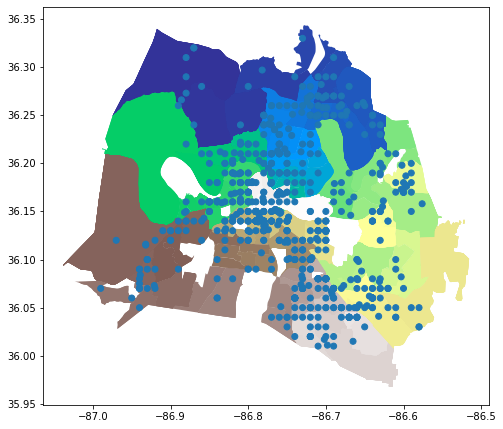

In [123]:
ax = polygon_nash.plot(column='TRACTCE', figsize = (8, 10), cmap='terrain')
burglary_by_tract.plot(ax = ax, column = 'offense_description')
plt.show();

In [124]:
#exports burglary_by_tract csv to data folder for use in question 3
burglary_by_tract.to_csv("../geospatial_api-silver-sharks/data/burglary_by_tract.csv")